load data
plot data

In [1]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [2]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [3]:
from tfumap.paths import FIGURE_DIR, save_fig

In [4]:
save_loc = DATA_DIR / 'reconstruction_acc' 

In [5]:
datasets = [
    'cassins_dtw',
    'cifar10',
    'fmnist',
    'macosko2015',
    'mnist'
]

In [6]:
recon_acc = pd.concat([pd.read_pickle(save_loc / (dataset + '.pickle')) for dataset in datasets])
recon_acc[:3]

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,AE,2,cassins_dtw,0.002750,0.019565,0.011422,-8.223918e+05
1,AE,64,cassins_dtw,0.002769,0.019662,0.011546,-4.694638e+07
2,network,2,cassins_dtw,0.002793,0.020141,0.012264,-6.232119e+05


In [7]:
recon_acc = pd.concat(
    [pd.concat([pd.read_pickle(i) for i in list((save_loc / 'vae').glob('*/*.pickle'))])    , recon_acc]
)
recon_acc.loc[recon_acc.dataset == 'cassins', 'dataset'] = 'cassins_dtw'

In [8]:
recon_acc = pd.concat(
    [pd.concat([pd.read_pickle(i)[:1] for i in list((save_loc / 'ae_only').glob('*/*.pickle'))])    , recon_acc]
)

In [9]:
median_df = (
    recon_acc[["method_", "dimensions", "dataset", "MSE"]]
    .groupby(["method_", "dimensions", "dataset"])
    .median()
)
median_df = median_df.T.melt()
median_df

,method_,dimensions,dataset,value
0,AE,2,cassins_dtw,0.002750
1,AE,2,cifar10,0.036410
2,AE,2,fmnist,0.024047
3,AE,2,macosko2015,0.000507
4,AE,2,mnist,0.035955
5,AE,64,cassins_dtw,0.002769
6,AE,64,cifar10,0.009391
7,AE,64,fmnist,0.009165
8,AE,64,macosko2015,0.000277
9,AE,64,mnist,0.002684


In [10]:
import seaborn as sns

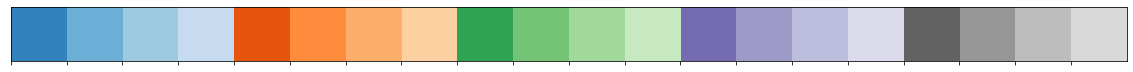

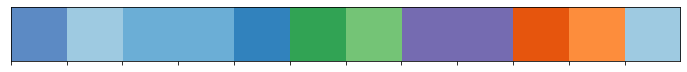

In [11]:
pal20c = sns.color_palette('tab20c', 20)
sns.palplot(pal20c)
hue_dict = {
    "umap-learn": list(np.array(pal20c[3])**4),
    "direct": pal20c[2],
    "AE": pal20c[1],
    "autoencoder": pal20c[1],
    "network": pal20c[0],
    'vae':  pal20c[8], 
    'ae_only':  pal20c[9],
    "pca":  pal20c[12],
    "PCA":  pal20c[12],
    "TSNE": pal20c[4], 
    "parametric-tsne":pal20c[5],
    "network-cpu": pal20c[2],

}
sns.palplot([hue_dict[i] for i in hue_dict.keys()])

In [13]:
hue_list = ["umap-learn", "AE", "network",  'vae', 'ae_only', "pca"]

In [84]:
median_df.method_.unique()

array(['AE', 'ae_only', 'network', 'pca', 'umap-learn', 'vae'],
      dtype=object)

In [97]:
# set parametric UMAP at 1
median_df['baseline'] = np.nan
for dataset in median_df.dataset.unique():
    for dimension in median_df.dimensions.unique():
        """dataset_dim = median_df[
            (median_df.dimensions == dimension) &
            (median_df.dataset == dataset) &
            (median_df.method_ == 'PCA')
        ]['value'].values[0]"""
        dataset_dim = np.mean(median_df[
            (median_df.dimensions == dimension) &
            (median_df.dataset == dataset) 
        ]['value'].values)
        #print(dataset_dim)
        dataset_dim = median_df.loc[
            (median_df.dimensions == dimension) &
            (median_df.dataset == dataset),
            'baseline'
        ] = dataset_dim
#median_df['relative_value'] = median_df['value'] # - median_df['baseline']
median_df['relative_value'] = median_df['value']  / median_df['baseline']
median_df[:3]

,method_,dimensions,dataset,value,baseline,relative_value
0,AE,2,cassins_dtw,0.002750,0.008501,0.323544
1,AE,2,cifar10,0.036410,0.036545,0.996317
2,AE,2,fmnist,0.024047,0.030194,0.796415


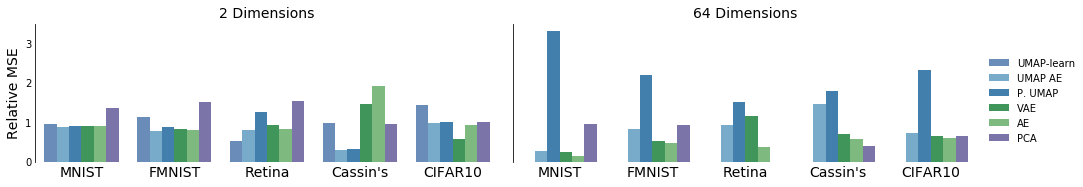

In [98]:
import matplotlib as mpl
axes = {'labelsize': 14,
        'titlesize': 14,}
mpl.rc('axes', **axes)
mpl.rcParams['xtick.labelsize'] = 14

fg = sns.catplot(
    x="dataset",
    y="relative_value",
    hue="method_",
    hue_order=hue_list,
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dimensions",
    height=2.75, 
    aspect=2.5,
    data=median_df,
    kind="bar",
    palette=[hue_dict[i] for i in hue_list],
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Relative MSE")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP-learn')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'AE'))[0][0]].set_text('UMAP AE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'pca'))[0][0]].set_text('PCA')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'vae'))[0][0]].set_text('VAE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'ae_only'))[0][0]].set_text('AE')
#fg._legend.texts[3].set_text("PCA")

#ax.set_yscale('log');
#ax.set_ylim([1e-2,-1])
#ax.set_yscale('symlog')
#fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')
#ax.set_yscale('log')
#ax.set_ylim([0, 2])
save_fig(FIGURE_DIR/'recon_acc_relative', save_pdf=True, dpi=300, pad_inches=0.1)

In [56]:
median_df[:3]

,method_,dimensions,dataset,value,baseline,relative_value
0,AE,2,cassins_dtw,0.002750,0.002793,0.002750
1,AE,2,cifar10,0.036410,0.036922,0.036410
2,AE,2,fmnist,0.024047,0.026576,0.024047


In [40]:
results_df = median_df.sort_values(by=['dataset', 'dimensions']).set_index(['dataset', 'dimensions'])
results_df = results_df.pivot_table(index=['dataset','dimensions'], 
                      columns='method_', 
                      values='value', 
                      aggfunc='first')
results_df

method_                       AE   ae_only   network       pca  umap-learn  \
dataset     dimensions                                                       
cassins_dtw 2           0.002750  0.016298  0.002793  0.008243    0.008452   
            64          0.002769  0.001090  0.003355  0.000769         NaN   
cifar10     2           0.036410  0.034399  0.036922  0.037042    0.052772   
            64          0.009391  0.008022  0.029988  0.008396         NaN   
fmnist      2           0.024047  0.024383  0.026576  0.046097    0.034726   
            64          0.009165  0.005404  0.024062  0.010376         NaN   
macosko2015 2           0.000507  0.000529  0.000799  0.000974    0.000339   
            64          0.000277  0.000112  0.000451       NaN         NaN   
mnist       2           0.035955  0.036907  0.037375  0.055667    0.039312   
            64          0.002684  0.001617  0.031332  0.009049         NaN   

method_                      vae  
dataset     dimensions            
cassins_dtw 2           0.012467  
            64          0.001331  
cifar10     2           0.021724  
            64          0.008449  
fmnist      2           0.025333  
            64          0.005772  
macosko2015 2           0.000594  
            64          0.000345  
mnist       2           0.037106  
            64          0.002376

In [49]:
print(
    results_df[['umap-learn', 'network', 'AE', 'ae_only', 'vae', 'pca']].round(4).to_latex()
    .replace("cassins\_dtw", "Cassin's")
    .replace("cifar10", "CIFAR10")
    .replace("fmnist", "FMNIST")
    .replace("mnist", "MNIST")
    .replace("macosko2015", "Retina")
    .replace("AE", "UMAP/AE")
    .replace("ae\_only", "AE")
    .replace("network", "P. UMAP")
    .replace("umap-learn", "UMAP")
    .replace("vae", "VAE")
    .replace("pca", "PCA")
)

\begin{tabular}{llrrrrrr}
\toprule
      & method\_ &  UMAP &  P. UMAP &      UMAP/AE &  AE &     VAE &     PCA \\
dataset & dimensions &             &          &         &          &         &         \\
\midrule
Cassin's & 2  &      0.0085 &   0.0028 &  0.0028 &   0.0163 &  0.0125 &  0.0082 \\
      & 64 &         NaN &   0.0034 &  0.0028 &   0.0011 &  0.0013 &  0.0008 \\
CIFAR10 & 2  &      0.0528 &   0.0369 &  0.0364 &   0.0344 &  0.0217 &  0.0370 \\
      & 64 &         NaN &   0.0300 &  0.0094 &   0.0080 &  0.0084 &  0.0084 \\
FMNIST & 2  &      0.0347 &   0.0266 &  0.0240 &   0.0244 &  0.0253 &  0.0461 \\
      & 64 &         NaN &   0.0241 &  0.0092 &   0.0054 &  0.0058 &  0.0104 \\
Retina & 2  &      0.0003 &   0.0008 &  0.0005 &   0.0005 &  0.0006 &  0.0010 \\
      & 64 &         NaN &   0.0005 &  0.0003 &   0.0001 &  0.0003 &     NaN \\
MNIST & 2  &      0.0393 &   0.0374 &  0.0360 &   0.0369 &  0.0371 &  0.0557 \\
      & 64 &         NaN &   0.0313 &  0.0027 &   0.0016 & 